In [2]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Accelerating VQEs with quantum natural gradient
===============================================

*Authors: Maggie Li, Lana Bozanic, Sukin Sim (<ssim@g.harvard.edu>).
Last updated: 8 Apr 2021.*

This tutorial showcases how one can apply quantum natural gradients
(QNG) \[\#stokes2019\]\_ \[\#yamamoto2019\]\_ to accelerate the
optimization step of the Variational Quantum Eigensolver (VQE) algorithm
\[\#peruzzo2014\]\_. We will implement two small examples: estimating
the ground state energy of (1) a single-qubit VQE problem, which we can
visualize using the Bloch sphere, and (2) the hydrogen molecule.

Before going through this tutorial, we recommend that readers refer to
the QNG tutorial &lt;/demos/tutorial\_quantum\_natural\_gradient&gt; and
VQE tutorial &lt;/demos/tutorial\_vqe&gt; for overviews of quantum
natural gradient and the variational quantum eigensolver algorithm,
respectively. Let's get started!

(1) Single-qubit VQE example
----------------------------

The first step is to import the required libraries and packages:


In [3]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

For this simple example, we consider the following single-qubit
Hamiltonian: $\sigma_x + \sigma_z$.

We define the device:


In [4]:
dev = qml.device("default.qubit", wires=1)

For the variational ansatz, we use two single-qubit rotations, which the
user may recognize from a previous
tutorial &lt;/demos/tutorial\_qubit\_rotation&gt; on qubit rotations.


In [5]:
def circuit(params, wires=0):
    qml.RX(params[0], wires=wires)
    qml.RY(params[1], wires=wires)

We then define our cost function which supports the computation of
block-diagonal or diagonal approximations to the Fubini-Study metric
tensor \[\#stokes2019\]\_. This tensor is a crucial component for
optimizing with quantum natural gradients.


In [6]:
coeffs = [1, 1]
obs = [qml.PauliX(0), qml.PauliZ(0)]

H = qml.Hamiltonian(coeffs, obs)

@qml.qnode(dev)
def cost_fn(params):
    circuit(params)
    return qml.expval(H)

To analyze the performance of quantum natural gradient on VQE
calculations, we set up and execute optimizations using the
`GradientDescentOptimizer` (which does not utilize quantum gradients)
and the `QNGOptimizer` that uses the block-diagonal approximation to the
metric tensor.

To perform a fair comparison, we fix the initial parameters for the two
optimizers.


In [7]:
init_params = np.array([3.97507603, 3.00854038], requires_grad=True)

We will carry out each optimization over a maximum of 500 steps. As was
done in the VQE tutorial, we aim to reach a convergence tolerance of
around $10^{-6}$. We use a step size of 0.01.


In [8]:
max_iterations = 500
conv_tol = 1e-06
step_size = 0.01

First, we carry out the VQE optimization using the standard gradient
descent method.


In [9]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 0.56743624 Ha,  Convergence parameter = 0.00973536 Ha
Iteration = 20,  Energy = 0.38709233 Ha,  Convergence parameter = 0.00821261 Ha
Iteration = 40,  Energy = 0.24420954 Ha,  Convergence parameter = 0.00616395 Ha
Iteration = 60,  Energy = 0.14079686 Ha,  Convergence parameter = 0.00435028 Ha
Iteration = 80,  Energy = 0.06758408 Ha,  Convergence parameter = 0.00314443 Ha
Iteration = 100,  Energy = 0.01128048 Ha,  Convergence parameter = 0.00262544 Ha
Iteration = 120,  Energy = -0.04175219 Ha,  Convergence parameter = 0.00278160 Ha
Iteration = 140,  Energy = -0.10499504 Ha,  Convergence parameter = 0.00361450 Ha
Iteration = 160,  Energy = -0.19195848 Ha,  Convergence parameter = 0.00511056 Ha
Iteration = 180,  Energy = -0.31444953 Ha,  Convergence parameter = 0.00708743 Ha
Iteration = 200,  Energy = -0.47706980 Ha,  Convergence parameter = 0.00900220 Ha
Iteration = 220,  Energy = -0.66993027 Ha,  Convergence parameter = 0.01001574 Ha
Iteration = 240,  Energy = -

We then repeat the process for the optimizer employing quantum natural
gradients:


In [10]:
opt = qml.QNGOptimizer(stepsize=step_size, approx="block-diag")

params = init_params

qngd_param_history = [params]
qngd_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    # Compute energy
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 0.51052556 Ha,  Convergence parameter = 0.06664604 Ha
Iteration = 20,  Energy = -0.90729965 Ha,  Convergence parameter = 0.05006082 Ha
Iteration = 40,  Energy = -1.35504644 Ha,  Convergence parameter = 0.00713113 Ha
Iteration = 60,  Energy = -1.40833787 Ha,  Convergence parameter = 0.00072399 Ha
Iteration = 80,  Energy = -1.41364035 Ha,  Convergence parameter = 0.00007078 Ha
Iteration = 100,  Energy = -1.41415774 Ha,  Convergence parameter = 0.00000689 Ha

Final value of the energy = -1.41420585 Ha
Number of iterations =  117


Visualizing the results
=======================

For single-qubit examples, we can visualize the optimization process in
several ways.

For example, we can track the energy history:


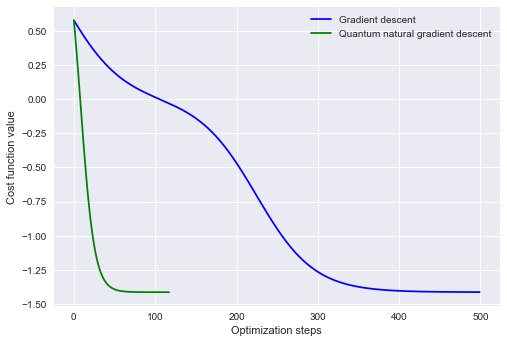

In [11]:
plt.style.use("seaborn")
plt.plot(gd_cost_history, "b", label="Gradient descent")
plt.plot(qngd_cost_history, "g", label="Quantum natural gradient descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Or we can visualize the optimization path in the parameter space using a
contour plot. Energies at different grid points have been pre-computed,
and they can be downloaded by clicking
here&lt;../demonstrations/vqe\_qng/param\_landscape.npy&gt;.


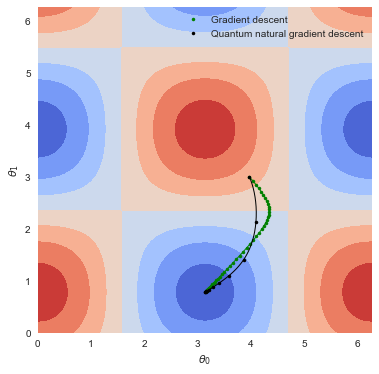

In [15]:
# Discretize the parameter space
theta0 = np.linspace(0.0, 2.0 * np.pi, 100)
theta1 = np.linspace(0.0, 2.0 * np.pi, 100)

# Load energy value at each point in parameter space
parameter_landscape = np.load("param_landscape.npy")

# Plot energy landscape
fig, axes = plt.subplots(figsize=(6, 6))
cmap = plt.cm.get_cmap("coolwarm")
contour_plot = plt.contourf(theta0, theta1, parameter_landscape, cmap=cmap)
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")

# Plot optimization path for gradient descent. Plot every 10th point.
gd_color = "g"
plt.plot(
    np.array(gd_param_history)[::10, 0],
    np.array(gd_param_history)[::10, 1],
    ".",
    color=gd_color,
    linewidth=1,
    label="Gradient descent",
)
plt.plot(
    np.array(gd_param_history)[:, 0],
    np.array(gd_param_history)[:, 1],
    "-",
    color=gd_color,
    linewidth=1,
)

# Plot optimization path for quantum natural gradient descent. Plot every 10th point.
qngd_color = "k"
plt.plot(
    np.array(qngd_param_history)[::10, 0],
    np.array(qngd_param_history)[::10, 1],
    ".",
    color=qngd_color,
    linewidth=1,
    label="Quantum natural gradient descent",
)
plt.plot(
    np.array(qngd_param_history)[:, 0],
    np.array(qngd_param_history)[:, 1],
    "-",
    color=qngd_color,
    linewidth=1,
)

plt.legend()
plt.show()

Here, the blue regions indicate states with lower energies, and the red
regions indicate states with higher energies. We can see that the
`QNGOptimizer` takes a more direct route to the minimum in larger
strides compared to the path taken by the `GradientDescentOptimizer`.

Lastly, we can visualize the same optimization paths on the Bloch sphere
using routines from [QuTiP](http://qutip.org/). The result should look
like the following:

![](/demonstrations/vqe_qng/opt_paths_bloch.png){width="50%"}

where again the black markers and line indicate the path taken by the
`QNGOptimizer`, and the green markers and line indicate the path taken
by the `GradientDescentOptimizer`. Using this visualization method, we
can clearly see how the path using the `QNGOptimizer` tightly "hugs" the
curvature of the Bloch sphere and takes the shorter path.

Now, we will move onto a more interesting example: estimating the ground
state energy of molecular hydrogen.



References
==========
*Authors: Maggie Li, Lana Bozanic, Sukin Sim (<ssim@g.harvard.edu>).
Last updated: 8 Apr 2021.*
